In [ ]:
import torch
print(torch.__version__)

2.5.0+cu121


In [ ]:
!python --version

Python 3.10.12


# <font color = 'indianred'>**NER using DistilBert** </font>

**Objective:**

In this notebook, we aim to learn how to to do Named Entity Recognition using Encoder model (DistilBert). NER is a token level classification problem.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate seqeval -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer, DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast

In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
# data_folder = base_folder/'datasets/brown_corpus'

# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
conll_dataset = load_dataset('conll2003')

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [ ]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [ ]:
train_split = conll_dataset['train'].shuffle(seed=42).select(range(5000))
val_split = conll_dataset['validation'].shuffle(seed=42).select(range(1000))
test_split = conll_dataset['test'].shuffle(seed=42).select(range(1000))

In [ ]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
})

In [ ]:
class_names = conll_dataset['train'].features['ner_tags'].feature.names

In [ ]:
class_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [ ]:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

def align_targets(labels, word_ids):
    """
    Aligns the target labels based on word IDs, ensuring that words split into multiple tokens
    correctly transition from B- tags to I- tags.

    Args:
    - labels (list): A list of labels to be aligned.
    - word_ids (list): A list of word IDs where each ID corresponds to a label in the 'labels' list.
                      If an ID is 'None', it means the word does not have a corresponding label.

    Returns:
    - list: A list of aligned labels. Special tokens have label -100.
            For words split across tokens, B- tags are transitioned to I- tags for subsequent tokens of the same word.
    """

    # Dictionary mapping from B- tag indices to corresponding I- tag indices
    begin2inside = {1:2, 3:4, 5:6, 7:8}

    aligned_labels = []
    last_id = None

    for word_id in word_ids:
        # Check if the current token is a special token (like [CLS], [SEP] etc.)
        if word_id is None:
            label = -100
        # Check if it's a new word (i.e., not part of the previous word)
        elif word_id != last_id:
            label = labels[word_id]
        else:  # Token is part of the same word as the previous token
            label = labels[word_id]
            # If the label starts with a B-, we transition it to the corresponding I- tag
            if label in begin2inside:
                label = begin2inside[label]

        # Add the label to the aligned list
        aligned_labels.append(label)

        # Update the last_id for the next iteration
        last_id = word_id

    return aligned_labels

In [ ]:
def tokenize_fn(batch):
    """
    Tokenizes a batch of sequences and aligns the target labels with the tokenized outputs.

    Args:
    - batch (dict): A dictionary containing:
        * 'tokens': A list of lists where each inner list contains tokens of a sequence.
        * 'tags': A list of lists where each inner list contains POS tags corresponding to the 'tokens'.

    Returns:
    - dict: A dictionary containing tokenized inputs and their corresponding aligned labels.
    """

    # Tokenize the 'tokens' from the batch. This returns various fields like 'input_ids', 'attention_mask', etc.
    # 'is_split_into_words=True' indicates the input is already tokenized into words.
    # 'truncation=True' ensures sequences longer than the model's max length are truncated.
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)

    # Extract the original labels/tags from the batch.
    labels_batch = batch['ner_tags']

    # This list will store the labels aligned with the tokenized input.
    aligned_labels_batch = []

    # Iterate over each example in the batch.
    for i, labels in enumerate(labels_batch):
        # Obtain the word IDs for the tokenized example. This helps in aligning the original labels with the tokens.
        word_ids = tokenized_inputs.word_ids(i)

        # Align the original labels with the tokenized example and append to the aligned_labels_batch list.
        aligned_labels_batch.append(align_targets(labels, word_ids))

    # The HuggingFace trainer expects the labels for token classification tasks to be under the key 'labels'.
    # Store the aligned labels in the 'labels' key of the tokenized_inputs dictionary.
    tokenized_inputs['labels'] = aligned_labels_batch

    return tokenized_inputs

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [ ]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Downaload and Modify Model Config File**

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id



##  <font color = 'indianred'> **6.2 Download pre-trained model**

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [ ]:
seqeval_metric = evaluate.load('seqeval')
def compute_metrics(logits_and_labels):
    """
    Compute sequence tagging metrics using the seqeval metric.

    Args:
    - logits_and_labels (tuple): A tuple containing model logits and true labels.

    Returns:
    - dict: A dictionary containing precision, recall, f1-score, and accuracy.
    """

    # Separate logits and labels from the input tuple
    logits, true_labels = logits_and_labels

    # Obtain predicted label indices by selecting the label with the highest logit value for each token
    predicted_indices = np.argmax(logits, axis=-1)  # Shape: (batch_size, sequence_length)

    # Convert label indices to their string representation, ignoring special tokens (label index = -100)
    string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    # Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
    string_predictions = [
        [class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
    ]

    # Compute the metrics using seqeval
    metrics_results = seqeval_metric.compute(predictions=string_predictions, references=string_true_labels, zero_division=0)

    return {
        'precision': metrics_results['overall_precision'],
        'recall': metrics_results['overall_recall'],
        'f1': metrics_results['overall_f1'],
        'accuracy': metrics_results['overall_accuracy']
    }

## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/ner_dbert")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [ ]:
data_collator =  DataCollatorForTokenClassification(tokenizer = tokenizer,
                                                  padding=True,
                                                  label_pad_token_id=-100,
                                                  return_tensors='pt')

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


<ipython-input-43-4175ce21dbfa>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = nlp_course_fall_2024-ner

env: WANDB_PROJECT=nlp_course_fall_2024-ner


##  <font color = 'indianred'> **6.7 Training and Validation**

In [ ]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,0.155200,0.124920,0.766719,0.824415,0.794521,0.964212
40,0.136200,0.117317,0.756757,0.827202,0.790413,0.965949
60,0.106700,0.105597,0.789720,0.847826,0.817742,0.970791
80,0.103900,0.103530,0.800732,0.853400,0.826228,0.970265
100,0.082100,0.099275,0.812764,0.858974,0.835230,0.970949
120,0.096300,0.096309,0.811024,0.861204,0.835361,0.972949
140,0.072800,0.096965,0.829229,0.863434,0.845986,0.974580
160,0.080800,0.090331,0.829527,0.870680,0.849606,0.975370
180,0.087000,0.091028,0.823436,0.865663,0.844022,0.973212
200,0.118100,0.087719,0.816702,0.866778,0.840995,0.973422


TrainOutput(global_step=626, training_loss=0.08406669948809443, metrics={'train_runtime': 104.7801, 'train_samples_per_second': 95.438, 'train_steps_per_second': 5.974, 'total_flos': 120830621314032.0, 'train_loss': 0.08406669948809443, 'epoch': 2.0})

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.06782490760087967,
 'eval_precision': 0.8851752021563343,
 'eval_recall': 0.915273132664437,
 'eval_f1': 0.8999725952315702,
 'eval_accuracy': 0.982843008262723,
 'eval_runtime': 1.0709,
 'eval_samples_per_second': 933.837,
 'eval_steps_per_second': 58.832,
 'epoch': 2.0}

In [ ]:
wandb.log({"eval_f1": eval_results["eval_f1"], "eval_loss": eval_results["eval_loss"] })

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
valid_output = trainer.predict(tokenized_dataset["valid"])
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)

(1000, 146, 9)
(1000, 146)


In [ ]:
valid_preds = np.argmax(valid_output.predictions, axis=2)
valid_labels = np.array(valid_output.label_ids.astype(int))


In [ ]:
mask = valid_labels != -100
filtered_predictions = valid_preds[mask]
filtered_labels = valid_labels[mask]

In [ ]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

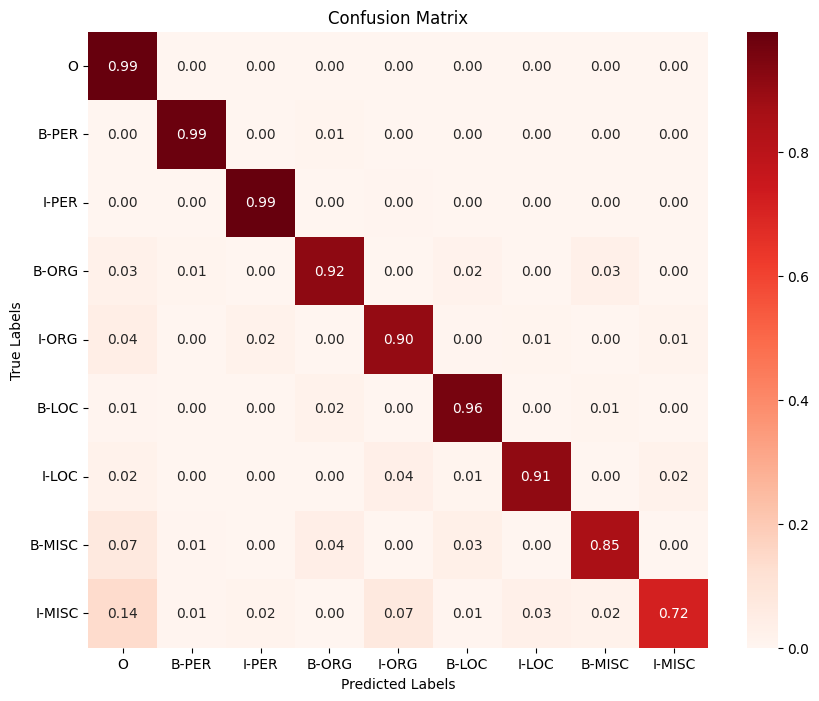

In [ ]:
plot_confusion_matrix(filtered_labels, filtered_predictions, class_labels=list(model.config.id2label.values()))


<font color = 'indianred'> *Get best checkpoint*</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 560.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/ner_dbert/checkpoint-560'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForTokenClassification.from_pretrained(checkpoint)

In [ ]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
test_set_tokenized

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [ ]:
test_set_tokenized = test_set_tokenized.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])

<font color = 'indianred'>*Training Arguments*</font>

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    )

<font color = 'indianred'>*Instantiate Trainer*</font>

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-73-1bf9d0a35ad5>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<font color = 'indianred'>*Evaluate using Trainer*</font>

In [ ]:
test_results= trainer.evaluate()

In [ ]:
test_results

{'eval_loss': 0.11496884375810623,
 'eval_model_preparation_time': 0.0019,
 'eval_precision': 0.8250577367205543,
 'eval_recall': 0.8734718826405868,
 'eval_f1': 0.8485748218527316,
 'eval_accuracy': 0.96875,
 'eval_runtime': 0.9314,
 'eval_samples_per_second': 1073.647,
 'eval_steps_per_second': 8.589}

In [ ]:
wandb.log({"eval_f1": eval_results["eval_f1"], "eval_loss": eval_results["eval_loss"] })

<font color = 'indianred'>*Confusion Matrix*</font>

In [ ]:
test_output = trainer.predict(test_set_tokenized)

In [ ]:
test_preds = np.argmax(test_output.predictions, axis=2)
test_labels = np.array(test_output.label_ids.astype(int))
mask = test_labels != -100
filtered_predictions = test_preds[mask]
filtered_labels = test_labels[mask]


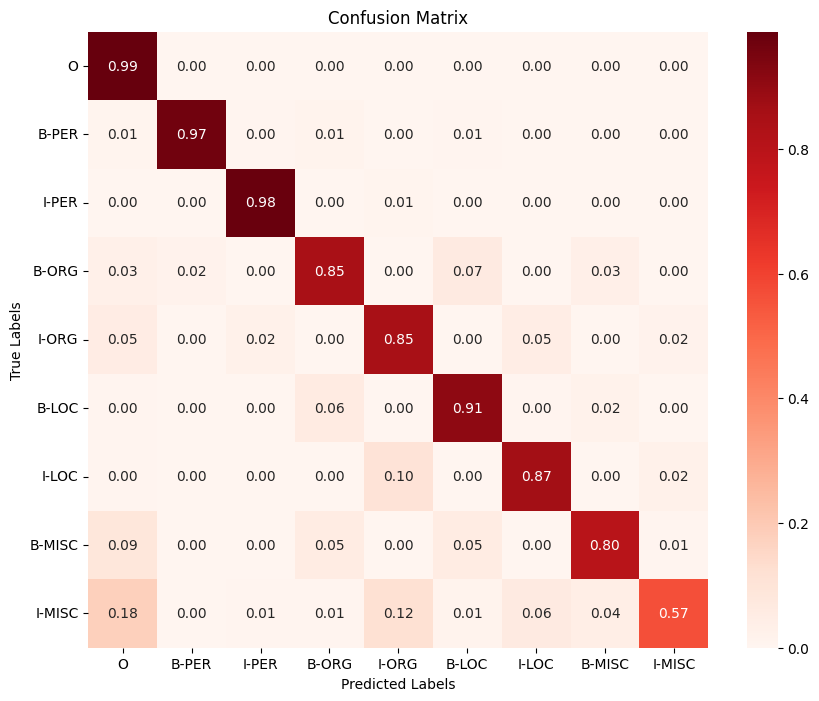

In [ ]:
plot_confusion_matrix(filtered_labels, filtered_predictions, class_labels=list(model.config.id2label.values()))

In [ ]:
wandb.finish()

eval/accuracy,▁▂▄▆▆▇▇▇▇▇▇█████████████████████████████
eval/f1,▁▁▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
eval/loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▅▅▆▆▆▇▇▇▇▇▇▇▇███▇█████████████████████
eval/recall,▁▁▅▅▆▆▇▇▇▇▇▇████████████████████████████
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁
eval/samples_per_second,███████▇█████▇████▁████████████▁███████▇
eval/steps_per_second,███████▇█████▇████▁████████████▁███████▇
eval_f1,▁▁
eval_loss,▁▁
test/accuracy,▁▁


# <Font color = 'indianred'> **8. Model Inference**



In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device='cpu',
    aggregation_strategy="simple",
    framework="pt")

<font color = 'indianred'> **Test the pipeline on a single example**

In [ ]:
idx=100
sample = " ".join(test_split['tokens'][idx])
print(sample)


Brian Shimer piloted USA III to a surprise victory in a World Cup two-man bobsleigh race on Saturday .


In [ ]:
preds = custom_pipeline(sample)
display(pd.DataFrame(preds))

,entity_group,score,word,start,end
0,PER,0.994654,brian shimer,0,12
1,ORG,0.767632,usa iii,21,28
2,MISC,0.925712,world cup,56,65


<font color = 'indianred'> **Test the pipeline on a large dataset**

In [ ]:
def preprocess_for_pipeline(example):
    return {"processed_text": " ".join(example['tokens'])}

test_split = test_split.map(preprocess_for_pipeline)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
test_split

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'processed_text'],
    num_rows: 1000
})

In [ ]:
preds = custom_pipeline(test_split['processed_text'], batch_size=16)

In [ ]:
preds[0:3]


[[{'entity_group': 'ORG',
   'score': 0.9930589,
   'word': 'hartford',
   'start': 0,
   'end': 8},
  {'entity_group': 'ORG',
   'score': 0.9925575,
   'word': 'boston',
   'start': 11,
   'end': 17}],
 [{'entity_group': 'PER',
   'score': 0.9913751,
   'word': 's. doull',
   'start': 0,
   'end': 8},
  {'entity_group': 'PER',
   'score': 0.98334634,
   'word': 'm. wasim',
   'start': 18,
   'end': 26},
  {'entity_group': 'PER',
   'score': 0.9688602,
   'word': 'waqar',
   'start': 31,
   'end': 36}],
 [{'entity_group': 'PER',
   'score': 0.99623984,
   'word': 'camilla martin',
   'start': 0,
   'end': 14},
  {'entity_group': 'LOC',
   'score': 0.99583226,
   'word': 'denmark',
   'start': 17,
   'end': 24},
  {'entity_group': 'PER',
   'score': 0.9959996,
   'word': 'wang chen',
   'start': 32,
   'end': 41},
  {'entity_group': 'LOC',
   'score': 0.9959097,
   'word': 'china',
   'start': 44,
   'end': 49}]]